# PROYECTO MICROCREDITO

In [1]:
!pip install lightgbm

##Importaciones

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from google.colab import drive
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
import lightgbm as lgb
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score, confusion_matrix, balanced_accuracy_score, classification_report, roc_curve
from sklearn.ensemble import RandomForestClassifier
from lightgbm import LGBMClassifier
from imblearn.over_sampling import SMOTE
from sklearn.model_selection import RandomizedSearchCV
from sklearn.tree import DecisionTreeClassifier
from imblearn.ensemble import EasyEnsembleClassifier, BalancedRandomForestClassifier
import pickle
from joblib import dump
import os

## Carga de datos

In [3]:
# Montar drive
drive.mount('/content/drive')

# Desmontar drive inmediatamente
#drive.flush_and_unmount()

Mounted at /content/drive


In [4]:
# Cargo los archivos de las particiones como un dataframe
X_train_seleccionado = pd.read_csv('/content/drive/MyDrive/proyecto_microcreditos/data/processed/X_train_sel.csv')
y_train = pd.read_csv('/content/drive/MyDrive/proyecto_microcreditos/data/processed/y_train.csv')
X_test_seleccionado = pd.read_csv('/content/drive/MyDrive/proyecto_microcreditos/data/processed/X_test_sel.csv')
y_test = pd.read_csv('/content/drive/MyDrive/proyecto_microcreditos/data/processed/y_test.csv')

In [5]:
# Configurar la opcion para ver todas las columnas
pd.set_option('display.max_columns', None)

In [6]:
# Configurar la opcion para ver 500 filas
pd.set_option('display.max_rows', 500)

## Modelo RandomForestClassifier

In [7]:
# Definición explícita de pesos
class_weights = {0: 1.0, 1: 	77670 / 18512}  # ≈ {0:1.0, 1:4.19}

# Entrenar un modelo RFC
rf = RandomForestClassifier(
    n_estimators=100,
    class_weight=class_weights,  # Pesos personalizados para el desbalance
    random_state=42
)

rf.fit(X_train_seleccionado, y_train)
y_pred = rf.predict(X_test_seleccionado)

print("Accuracy:", accuracy_score(y_test, y_pred))
print("Balanced Accuracy:", balanced_accuracy_score(y_test, y_pred))
print("F1 Score:", f1_score(y_test, y_pred, average='weighted'))
print("ROC AUC:", roc_auc_score(y_test, rf.predict_proba(X_test_seleccionado)[:, 1]))
print("\nClassification Report:\n", classification_report(y_test, y_pred))
print("\nConfusion Matrix:\n", confusion_matrix(y_test, y_pred))

/usr/local/lib/python3.11/dist-packages/sklearn/base.py:1389: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


Accuracy: 0.8033996984976868
Balanced Accuracy: 0.6095508233470501
F1 Score: 0.7839572819040027
ROC AUC: 0.7652295013688755

Classification Report:
               precision    recall  f1-score   support

           0       0.85      0.92      0.88     15534
           1       0.48      0.29      0.37      3703

    accuracy                           0.80     19237
   macro avg       0.66      0.61      0.62     19237
weighted avg       0.78      0.80      0.78     19237


Confusion Matrix:
 [[14365  1169]
 [ 2613  1090]]


## Subsampleo de X_train y y_train

In [8]:
# Combinar X_train y y_train en un solo DataFrame temporal
Xy_train = X_train_seleccionado.copy()
Xy_train['estado_general'] = y_train.values  # Asegurarse de que el índice coincida

# Separar clase 0 y clase 1
df_0 = Xy_train[Xy_train['estado_general'] == 0].copy()
df_1 = Xy_train[Xy_train['estado_general'] == 1].copy()

# Calcular variabilidad por fila (std en los features, sin la etiqueta)
features_0 = df_0.drop(columns=['estado_general'])
df_0['row_std'] = features_0.std(axis=1)

# Elegir porcentaje o número de filas a conservar
porcentaje_conservar = 0.35  # conservar el %
n_conservar = int(len(df_0) * porcentaje_conservar)

# Seleccionar las filas más variables
df_0_mas_variable = df_0.sort_values(by='row_std', ascending=False).head(n_conservar)

# Eliminar columna auxiliar
df_0_mas_variable = df_0_mas_variable.drop(columns=['row_std'])

# Recomponer el conjunto final de entrenamiento
df_train_final = pd.concat([df_0_mas_variable, df_1], ignore_index=True)

# Separar nuevamente X e y
X_train_subsampleado = df_train_final.drop(columns=['estado_general'])
y_train_subsampleado = df_train_final['estado_general']

# Mezclar recomendable
from sklearn.utils import shuffle
X_train_subsampleado, y_train_subsampleado = shuffle(X_train_subsampleado, y_train_subsampleado, random_state=42)

In [9]:
#n_conservar

In [10]:
#len(df_1)

In [11]:
# Definición explícita de pesos
rf_ss = RandomForestClassifier(
    n_estimators=100,
    class_weight='balanced',
    random_state=42
)

rf_ss.fit(X_train_subsampleado, y_train_subsampleado)
y_pred2 = rf_ss.predict(X_test_seleccionado)

print("Accuracy:", accuracy_score(y_test, y_pred2))
print("Balanced Accuracy:", balanced_accuracy_score(y_test, y_pred2))
print("F1 Score:", f1_score(y_test, y_pred2, average='weighted'))
print("ROC AUC:", roc_auc_score(y_test, rf_ss.predict_proba(X_test_seleccionado)[:, 1]))
print("\nClassification Report:\n", classification_report(y_test, y_pred2))
print("\nConfusion Matrix:\n", confusion_matrix(y_test, y_pred2))

Accuracy: 0.42735353745386495
Balanced Accuracy: 0.5747731031816091
F1 Score: 0.46044263584433504
ROC AUC: 0.6413898536434552

Classification Report:
               precision    recall  f1-score   support

           0       0.88      0.34      0.49     15534
           1       0.23      0.81      0.35      3703

    accuracy                           0.43     19237
   macro avg       0.55      0.57      0.42     19237
weighted avg       0.76      0.43      0.46     19237


Confusion Matrix:
 [[ 5205 10329]
 [  687  3016]]


## SMOTE y cambio de umbral

In [12]:
""" # Aplicar SMOTE SOLO en el set de entrenamiento
smote = SMOTE(random_state=42)
X_train_res, y_train_res = smote.fit_resample(X_train_seleccionado, y_train)

print("Antes de SMOTE:", np.bincount(y_train))
print("Después de SMOTE:", np.bincount(y_train_res))

# Entrenar el modelo
clf3 = RandomForestClassifier(class_weight='balanced', random_state=42)
clf3.fit(X_train_res, y_train_res)

# Predecir probabilidades
y_proba2 = clf3.predict_proba(X_test_seleccionado)[:, 1]

# Ajustar umbral (ejemplo con 0.3 en vez de 0.5)
threshold = 0.3
y_pred5 = (y_proba2 >= threshold).astype(int)

# Evaluar
print("ROC AUC:", roc_auc_score(y_test, y_proba2))
print("Balanced Accuracy:", balanced_accuracy_score(y_test, y_pred))
print(classification_report(y_test, y_pred))"""

' # Aplicar SMOTE SOLO en el set de entrenamiento\nsmote = SMOTE(random_state=42)\nX_train_res, y_train_res = smote.fit_resample(X_train_seleccionado, y_train)\n\nprint("Antes de SMOTE:", np.bincount(y_train))\nprint("Después de SMOTE:", np.bincount(y_train_res))\n\n# Entrenar el modelo\nclf3 = RandomForestClassifier(class_weight=\'balanced\', random_state=42)\nclf3.fit(X_train_res, y_train_res)\n\n# Predecir probabilidades\ny_proba2 = clf3.predict_proba(X_test_seleccionado)[:, 1]\n\n# Ajustar umbral (ejemplo con 0.3 en vez de 0.5)\nthreshold = 0.3\ny_pred5 = (y_proba2 >= threshold).astype(int)\n\n# Evaluar\nprint("ROC AUC:", roc_auc_score(y_test, y_proba2))\nprint("Balanced Accuracy:", balanced_accuracy_score(y_test, y_pred))\nprint(classification_report(y_test, y_pred))'

## EasyEnsembleClassifier

In [13]:
"""# Busqueda de hiperparametros
# Modelo base
base_tree = DecisionTreeClassifier(random_state=42)

# Definir el modelo EasyEnsemble con el nombre correcto del parámetro
eec = EasyEnsembleClassifier(
    estimator=base_tree,
    random_state=42
)

# Espacio de búsqueda de hiperparámetros (usando estimator__)
param_dist = {
    'n_estimators': [10, 20, 50, 100],
    'estimator__max_depth': [None, 5, 10, 15],
    'estimator__min_samples_split': [2, 5, 10],
    'estimator__min_samples_leaf': [1, 2, 4],
    'estimator__max_features': [None, 'sqrt', 'log2'],
    'sampling_strategy': ['auto', 0.5, 0.75, 1.0]
}

# Búsqueda aleatoria
random_search = RandomizedSearchCV(
    estimator=eec,
    param_distributions=param_dist,
    n_iter=20,  # número de combinaciones a probar
    scoring='balanced_accuracy',
    cv=3,
    random_state=42,
    n_jobs=-1,
    verbose=2
)

# Ajustar búsqueda
random_search.fit(X_train_seleccionado, y_train)

# Mostrar resultados
print("Mejores hiperparámetros:", random_search.best_params_)
print("Mejor balanced_accuracy en CV:", random_search.best_score_)"""

'# Busqueda de hiperparametros\n# Modelo base\nbase_tree = DecisionTreeClassifier(random_state=42)\n\n# Definir el modelo EasyEnsemble con el nombre correcto del parámetro\neec = EasyEnsembleClassifier(\n    estimator=base_tree,\n    random_state=42\n)\n\n# Espacio de búsqueda de hiperparámetros (usando estimator__)\nparam_dist = {\n    \'n_estimators\': [10, 20, 50, 100],\n    \'estimator__max_depth\': [None, 5, 10, 15],\n    \'estimator__min_samples_split\': [2, 5, 10],\n    \'estimator__min_samples_leaf\': [1, 2, 4],\n    \'estimator__max_features\': [None, \'sqrt\', \'log2\'],\n    \'sampling_strategy\': [\'auto\', 0.5, 0.75, 1.0]\n}\n\n# Búsqueda aleatoria\nrandom_search = RandomizedSearchCV(\n    estimator=eec,\n    param_distributions=param_dist,\n    n_iter=20,  # número de combinaciones a probar\n    scoring=\'balanced_accuracy\',\n    cv=3,\n    random_state=42,\n    n_jobs=-1,\n    verbose=2\n)\n\n# Ajustar búsqueda\nrandom_search.fit(X_train_seleccionado, y_train)\n\n# Most

/usr/local/lib/python3.11/dist-packages/sklearn/ensemble/_bagging.py:878: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


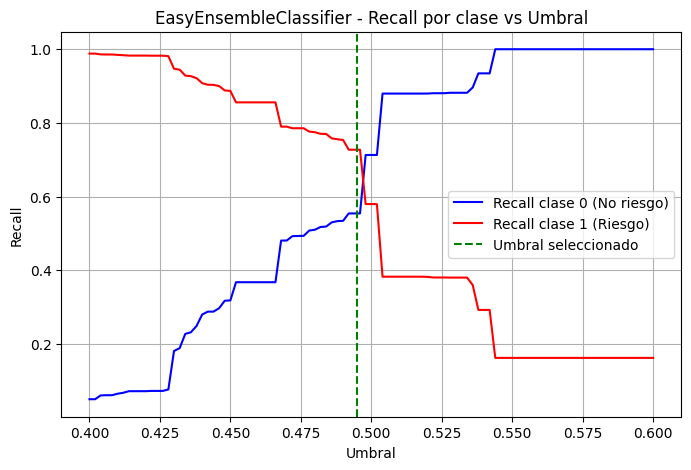

EasyEnsembleClassifier:
Balanced Accuracy: 0.6408224920788252
F1 Score promedio: 0.5445513135144373

Classification Report:
               precision    recall  f1-score   support

           0       0.90      0.55      0.68     15534
           1       0.28      0.73      0.40      3703

    accuracy                           0.59     19237
   macro avg       0.59      0.64      0.54     19237
weighted avg       0.78      0.59      0.63     19237

Confusion Matrix:
 [[8612 6922]
 [1010 2693]]


In [14]:
# Entrenar
eec = EasyEnsembleClassifier(n_estimators=50, n_jobs=-1, random_state=42)
eec.fit(X_train_seleccionado, y_train)

# Probabilidades clase positiva (1)
y_proba_eec = eec.predict_proba(X_test_seleccionado)[:, 1]

# Umbrales
thresholds_eec = np.linspace(0.4, 0.6, 101)
recall_class_0_eec = []
recall_class_1_eec = []

for thr in thresholds_eec:
    y_pred_temp = (y_proba_eec >= thr).astype(int)
    recall_class_0_eec.append(recall_score(y_test, y_pred_temp, pos_label=0))
    recall_class_1_eec.append(recall_score(y_test, y_pred_temp, pos_label=1))

# Gráfico
plt.figure(figsize=(8, 5))
plt.plot(thresholds_eec, recall_class_0_eec, label="Recall clase 0 (No riesgo)", color="blue")
plt.plot(thresholds_eec, recall_class_1_eec, label="Recall clase 1 (Riesgo)", color="red")
plt.axvline(x=0.495, color="green", linestyle="--", label="Umbral seleccionado")
plt.xlabel("Umbral")
plt.ylabel("Recall")
plt.title("EasyEnsembleClassifier - Recall por clase vs Umbral")
plt.legend()
plt.grid(True)
plt.show()

# Evaluar
threshold_eec = 0.495
y_pred_eec = (y_proba_eec >= threshold_eec).astype(int)

print("EasyEnsembleClassifier:")
print("Balanced Accuracy:", balanced_accuracy_score(y_test, y_pred_eec))
print("F1 Score promedio:", f1_score(y_test, y_pred_eec, average='macro'))
print("\nClassification Report:\n", classification_report(y_test, y_pred_eec))
print("Confusion Matrix:\n", confusion_matrix(y_test, y_pred_eec))

## Balanced Random Forest

In [15]:
"""# Busqueda de hiperparametros
# Espacio de búsqueda
param_dist_brf = {
    'n_estimators': [100, 200, 300, 500],  # cantidad de árboles
    'max_depth': [ 15, 20, 25, 30],  # profundidad máxima
    'min_samples_split': [2, 5, 10],  # mínimo de muestras para dividir
    'min_samples_leaf': [1, 2, 4],  # mínimo de muestras en una hoja
    'max_features': ['sqrt', 'log2', None],  # número de features usadas
    'class_weight': [None, 'balanced', 'balanced_subsample',
                     {0: 1.0, 1: len(y_train[y_train==0]) / len(y_train[y_train==1])}],  # pesos de clase
    'bootstrap': [True, False]  # si hacer muestreo con reemplazo
}

# Definir el modelo
brf = BalancedRandomForestClassifier(random_state=42)

# Búsqueda aleatoria
random_search_brf = RandomizedSearchCV(
    estimator=brf,
    param_distributions=param_dist_brf,
    n_iter=20,  # cantidad de combinaciones a probar
    scoring='f1_macro',  # métrica que optimizamos
    cv=3,  # validación cruzada
    random_state=42,
    n_jobs=-1,  # todos los núcleos
    verbose=2
)

# Entrenar búsqueda
random_search_brf.fit(X_train_seleccionado, y_train)

# Resultados
print("Mejores hiperparámetros:", random_search_brf.best_params_)
print("Mejor balanced_accuracy en CV:", random_search_brf.best_score_)"""

'# Busqueda de hiperparametros\n# Espacio de búsqueda\nparam_dist_brf = {\n    \'n_estimators\': [100, 200, 300, 500],  # cantidad de árboles\n    \'max_depth\': [ 15, 20, 25, 30],  # profundidad máxima\n    \'min_samples_split\': [2, 5, 10],  # mínimo de muestras para dividir\n    \'min_samples_leaf\': [1, 2, 4],  # mínimo de muestras en una hoja\n    \'max_features\': [\'sqrt\', \'log2\', None],  # número de features usadas\n    \'class_weight\': [None, \'balanced\', \'balanced_subsample\',\n                     {0: 1.0, 1: len(y_train[y_train==0]) / len(y_train[y_train==1])}],  # pesos de clase\n    \'bootstrap\': [True, False]  # si hacer muestreo con reemplazo\n}\n\n# Definir el modelo\nbrf = BalancedRandomForestClassifier(random_state=42)\n\n# Búsqueda aleatoria\nrandom_search_brf = RandomizedSearchCV(\n    estimator=brf,\n    param_distributions=param_dist_brf,\n    n_iter=20,  # cantidad de combinaciones a probar\n    scoring=\'f1_macro\',  # métrica que optimizamos\n    cv=3, 

/usr/local/lib/python3.11/dist-packages/sklearn/base.py:1389: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


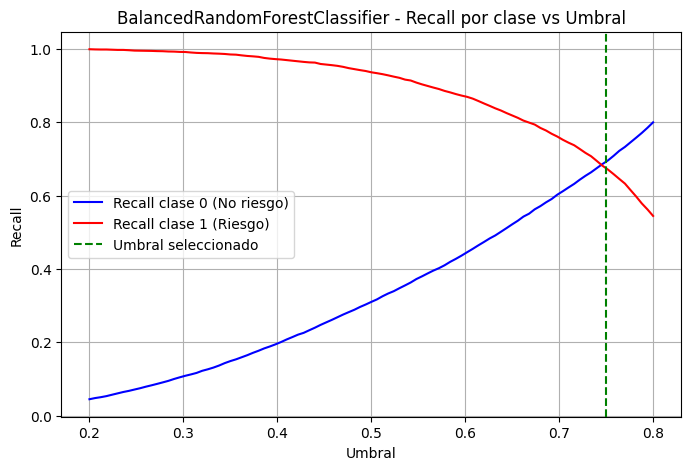

In [31]:
# Generar un modelo BalancedRandomForestClassifier
brf = BalancedRandomForestClassifier(
    n_estimators=10,
    max_depth=20,
    min_samples_leaf=10,
    class_weight=class_weights,
    n_jobs=-1,
    random_state=42
)
brf.fit(X_train_seleccionado, y_train)

# Probabilidades
y_proba_brf = brf.predict_proba(X_test_seleccionado)[:, 1]

# Umbrales
thresholds_brf = np.linspace(0.2, 0.8, 101)
recall_class_0_brf = []
recall_class_1_brf = []

for thr in thresholds_brf:
    y_pred_temp = (y_proba_brf >= thr).astype(int)
    recall_class_0_brf.append(recall_score(y_test, y_pred_temp, pos_label=0))
    recall_class_1_brf.append(recall_score(y_test, y_pred_temp, pos_label=1))

umbral=0.75

# Gráfico
plt.figure(figsize=(8, 5))
plt.plot(thresholds_brf, recall_class_0_brf, label="Recall clase 0 (No riesgo)", color="blue")
plt.plot(thresholds_brf, recall_class_1_brf, label="Recall clase 1 (Riesgo)", color="red")
plt.axvline(x=umbral, color="green", linestyle="--", label="Umbral seleccionado")
plt.xlabel("Umbral")
plt.ylabel("Recall")
plt.title("BalancedRandomForestClassifier - Recall por clase vs Umbral")
plt.legend()
plt.grid(True)
plt.show()

In [32]:
def evaluar_modelo(modelo, X_train, y_train, X_test, y_test, threshold):
    # ====== TRAIN ======
    y_proba_train = modelo.predict_proba(X_train)[:, 1]
    y_pred_train = (y_proba_train >= threshold).astype(int)

    print("\n--- MÉTRICAS TRAIN ---")
    print("ROC AUC:", roc_auc_score(y_train, y_proba_train))
    print("Balanced Accuracy:", balanced_accuracy_score(y_train, y_pred_train))
    print("F1 Score macro:", f1_score(y_train, y_pred_train, average='macro'))
    print(classification_report(y_train, y_pred_train))
    print("Confusion Matrix:\n", confusion_matrix(y_train, y_pred_train))

    # ====== TEST ======
    y_proba_test = modelo.predict_proba(X_test)[:, 1]
    y_pred_test = (y_proba_test >= threshold).astype(int)

    print("\n--- MÉTRICAS TEST ---")
    print("ROC AUC:", roc_auc_score(y_test, y_proba_test))
    print("Balanced Accuracy:", balanced_accuracy_score(y_test, y_pred_test))
    print("F1 Score macro:", f1_score(y_test, y_pred_test, average='macro'))
    print(classification_report(y_test, y_pred_test))
    print("Confusion Matrix:\n", confusion_matrix(y_test, y_pred_test))

In [33]:
# BalancedRandomForestClassifier
evaluar_modelo(brf, X_train_seleccionado, y_train, X_test_seleccionado, y_test, threshold=umbral)


--- MÉTRICAS TRAIN ---
ROC AUC: 0.8485480585530168
Balanced Accuracy: 0.7531622831645661
F1 Score macro: 0.6732914272305923
              precision    recall  f1-score   support

           0       0.93      0.72      0.81     62136
           1       0.40      0.78      0.53     14809

    accuracy                           0.73     76945
   macro avg       0.67      0.75      0.67     76945
weighted avg       0.83      0.73      0.76     76945

Confusion Matrix:
 [[44917 17219]
 [ 3207 11602]]

--- MÉTRICAS TEST ---
ROC AUC: 0.7608248956641275
Balanced Accuracy: 0.6834254765647652
F1 Score macro: 0.618811654036777
              precision    recall  f1-score   support

           0       0.90      0.69      0.78     15534
           1       0.34      0.67      0.46      3703

    accuracy                           0.69     19237
   macro avg       0.62      0.68      0.62     19237
weighted avg       0.79      0.69      0.72     19237

Confusion Matrix:
 [[10762  4772]
 [ 1207  2496]

## Guardar el modelo

In [19]:
carpeta = '/content/drive/MyDrive/proyecto_microcreditos/modelos'
os.makedirs(carpeta, exist_ok=True)
ruta_archivo = os.path.join(carpeta, 'modelo_bfr.pkl')
dump(brf, ruta_archivo)

['/content/drive/MyDrive/proyecto_microcreditos/modelos/modelo_bfr.pkl']